In [1]:
from collections import Counter
import pandas as pd
import numpy as np
import ast

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
import scipy.stats as stats
from itertools import combinations

from CAI import RSCU

# Calculate and show the RSCU for secondary structure and sequence position

### Function to calculate RSCU
The RSCU is calculate based on Sharp PM, Li WH. An evolutionary perspective on synonymous codon usage in unicellular organisms. Journal of Molecular Evolution. 1986;24(1-2):28–38. doi: 10.1007/BF02099948

X_ij = observed number of occurrences of the j-th codon for the i-th amino acid, n_i = number of synonymous codons for the i-th amino acid 
$$ RSCU = \frac{X_{ij}}{\frac{1}{n_i} \sum_{k=1}^{n_j} X_{ij}} $$

### Set data to analyse and split into 3 sequence position (start, between, end)

In [2]:
savefig = False # define if figures should be saved

# load the data and convert the secondary structure to a list
data = pd.read_csv('/Users/dominiquefastus/master_project/NuStru/Example/examples_organism/example_nustru_ecoli.csv', converters={'secondary_structure': ast.literal_eval}, nrows=100)   
data['secondary_structure'] = data['secondary_structure'].apply(lambda x: list(x.items())) 

# create new columns for the protein sequence split into 3 parts (start, between, end)
data['nucleotide_sequence_start'], data['nucleotide_sequence_between'], data['nucleotide_sequence_end'] = data['nucleotide_sequence'].str[:60], data['nucleotide_sequence'].str[60:-60], data['nucleotide_sequence'].str[-60:]
data['protein_sequence_start'], data['protein_sequence_between'], data['protein_sequence_end'] = data['protein_sequence'].str[:20], data['protein_sequence'].str[20:-20], data['protein_sequence'].str[-20:]
# due to the splitting to 20 positions start and end, 
# there will be empty rows for short sequeneces, so we delete them (not optimal)
data = data[data['nucleotide_sequence_between']!= '']

# create new columns for the secondary structure split into 3 parts (start, between, end)
# convert the secondary structure dictionary to a string (whole sequence and ranges)
data['secstru_sequence_start'], data['secstru_sequence_between'], data['secstru_sequence_end'] = data['secondary_structure'].apply(lambda x: x[:20]), data['secondary_structure'].apply(lambda x: x[20:-20]), data['secondary_structure'].apply(lambda x: x[-20:])
data['secstru_sequence_start'], data['secstru_sequence_between'], data['secstru_sequence_end'] = data['secstru_sequence_start'].apply(lambda x: "".join(dict(x).values())), data['secstru_sequence_between'].apply(lambda x: "".join(dict(x).values())), data['secstru_sequence_end'].apply(lambda x: "".join(dict(x).values()))
data['secondary_structure'] = data['secondary_structure'].apply(lambda x: "".join(dict(x).values()))


### Define functions and codon table

In [3]:
# Define the standard genetic code with stop codons
codon_table = {
    'TTT': 'F', 'TTC': 'F', 'TTA': 'L', 'TTG': 'L',
    'TCT': 'S', 'TCC': 'S', 'TCA': 'S', 'TCG': 'S',
    'TAT': 'Y', 'TAC': 'Y', 'TAA': '*', 'TAG': '*',
    'TGT': 'C', 'TGC': 'C', 'TGA': '*', 'TGG': 'W',
    'CTT': 'L', 'CTC': 'L', 'CTA': 'L', 'CTG': 'L',
    'CCT': 'P', 'CCC': 'P', 'CCA': 'P', 'CCG': 'P',
    'CAT': 'H', 'CAC': 'H', 'CAA': 'Q', 'CAG': 'Q',
    'CGT': 'R', 'CGC': 'R', 'CGA': 'R', 'CGG': 'R',
    'ATT': 'I', 'ATC': 'I', 'ATA': 'I', 'ATG': 'M',
    'ACT': 'T', 'ACC': 'T', 'ACA': 'T', 'ACG': 'T',
    'AAT': 'N', 'AAC': 'N', 'AAA': 'K', 'AAG': 'K',
    'AGT': 'S', 'AGC': 'S', 'AGA': 'R', 'AGG': 'R',
    'GTT': 'V', 'GTC': 'V', 'GTA': 'V', 'GTG': 'V',
    'GCT': 'A', 'GCC': 'A', 'GCA': 'A', 'GCG': 'A',
    'GAT': 'D', 'GAC': 'D', 'GAA': 'E', 'GAG': 'E',
    'GGT': 'G', 'GGC': 'G', 'GGA': 'G', 'GGG': 'G'
}

def split_into_codons(sequence):
    """Split the sequence into codons"""
    # codons are a subset of 3 nucleotide, so we check again if the sequence is divisible by 3
    # due to previous filtering, this should be always the case
    return [sequence[i:i+3] for i in range(0, len(sequence), 3) if len(sequence[i:i+3]) == 3]

def map_rscu_to_codons(seq, rscu_values):
    """Map RSCU values to codons in each sequence"""
    # get a list of the codons of the nucleotide sequence (same order)
    codons = split_into_codons(seq)

    # return the calculated rscu values of each codon in the sequence
    mapped_rscu_value = [rscu_values.get(codon, np.nan) for codon in codons]

    # most RSCU calculations ignore the stop codons and since it is of no interest for the analysis, it is deleted
    if mapped_rscu_value[-1] in ['TAA','TAG','TGA']:
        mapped_rscu_value.pop()

    return mapped_rscu_value

# this was an initial function with the implemented rscu calculation
# to be more consistend with previous publications, it was choosen to use the CAI package
def calculate_rscu(seq_given=None, data=None, column=None):
    """Calculate RSCU values for the sequence (gene)"""
    
    # setup a list with the codons of the sequence
    # depending if only one or multiple sequences are given
    all_codons = []
    if isinstance(data, pd.DataFrame):
        for seq_row in data[column]:
            all_codons.extend(split_into_codons(seq_row))
    else:
        all_codons = split_into_codons(seq_given)

    # calculate the xth codon for the ith amino acid
    # setup a counter for both and get the absolute count from the codon list
    codon_counts = Counter(all_codons)
    amino_acid_counts = Counter()

    # Count the codon belonging to the same amino acid (number of amino acids)
    for codon, count in codon_counts.items():
        if codon in codon_table:
            # if the codon is in the codon table then get the belonging amino acid
            # add the count to the amino acid to get a total count
            # this is needed to calculate the expected codon usage
            amino_acid = codon_table[codon]
            amino_acid_counts[amino_acid] += count

    # now calculate the rscu values for each codon and store them in a dictionaryy
    rscu_values = {}
    for codon, count in codon_counts.items():
        if codon in codon_table:
            # get the number of synonymous codons for a codon, belonging to one amino acid
            amino_acid = codon_table[codon]
            synonymous_codons = [c for c, a in codon_table.items() if a == amino_acid]

            # the expected count or usage is the usage if all codons would be uniform and equally used
            # so we calculate it by the total counts of the codons, devided by the number of synonymous codons
            expected_count = amino_acid_counts[amino_acid] / len(synonymous_codons)

            # we can then calculate the rscu with the actual count of the codon (observed codon usage),
            # divided by the expected count (expted codon usage)
            rscu_values[codon] = (count / expected_count)

    # create a list of the rscu based on the codon order in the sequence
    rscu_results = map_rscu_to_codons(seq, rscu_values)

    if column == 'nucleotide_sequence_end':
        # most RSCU calculations ignore the stop codons and since it is of no interest for the analysis, it is deleted
        rscu_results.pop() 
        
    return rscu_results

def rscu_method_calculation(seq_given=None, data=None, column=None):
    """Calculates the RSCU values based on the CAI package"""
    # setup a list of sequences to calculate the codons from
    if isinstance(data, pd.DataFrame):
        seq = data[column].values.tolist()
    else:
        seq = [str(seq_given)]

    # there are multiple ways to calculate the rscu for codons based on literature
    # while rscu values for one sequence can indicate sequence (protein specific codon usage)
    # drawing the rscu from a set can give rise to species or overall codon usage
    if len(seq) == 1:
        # calculate the rscu for codons based on the sequence
        rscu_values = RSCU(seq)

        # create a list of the rscu based on the codon order in the sequence
        rscu_results = map_rscu_to_codons(seq_given, rscu_values)
        
        if column == 'nucleotide_sequence_end':
            # most RSCU calculations ignore the stop codons and since it is of no interest for the analysis, it is deleted
            rscu_results.pop() 
        
    elif len(seq) >= 1:
        # calculate the rscu for codons based on multiple sequences
        rscu_values = RSCU(seq)
        rscu_results = rscu_values
    else:
        print("Can't calculate rscu as no sequences provivded!")

    return rscu_results

def extract_secondary_structure(structure_string):
    """Extract secondary structure elements from structure string"""
    # convert string to list, a function is needed as it is applied to each row individually
    return list(structure_string) 

def align_rscu_and_structure(rscu_values, secondary_elements):
    """ Align lengths of RSCU values and secondary structure elements by trimming the excess"""
    # sometimes the sequence don't align equally
    # this can be done nicer and quicker (so it's probably redundant)
    min_length = min(len(rscu_values), len(secondary_elements))
    return rscu_values[:min_length], secondary_elements[:min_length]

### Calculate the RSCU for each sequence and extract the information for the range and structure

In [4]:
# process each sequence range
# create a data list to store the ranges with sequences and rscu values
# 1seq indicates that the rscu is calculated for one sequence
sequence_ranges = ['start', 'between', 'end']
flat_data_list_1seq = []
flat_data_list_rare_1seq = [] # we can also extract rare or no frequently used codons and store them here

# map RSCU values to codons in each sequence
data[f'rscu_values_sequence'] = data['nucleotide_sequence'].apply(lambda seq: rscu_method_calculation(seq_given=seq))

# loop over the ranges and map the rscu values to the secondary structures
for range_ in sequence_ranges:

    # Extract secondary structure elements for the individual ranges
    # transform elements to a list
    secstru_col = f'secstru_sequence_{range_}'
    data[f'secondary_structure_elements_{range_}'] = data[secstru_col].apply(extract_secondary_structure)

    # Align RSCU values with secondary structure elements
    # do it for the individual ranges
    if range_ == 'start':
        data[f'aligned_rscu_{range_}'], data[f'aligned_secondary_{range_}'] = zip(*data.apply(
            lambda row: align_rscu_and_structure(row[f'rscu_values_sequence'][:20], row[f'secondary_structure_elements_{range_}']), axis=1))
    elif range_ == 'between':
        data[f'aligned_rscu_{range_}'], data[f'aligned_secondary_{range_}'] = zip(*data.apply(
            lambda row: align_rscu_and_structure(row[f'rscu_values_sequence'][20:-20], row[f'secondary_structure_elements_{range_}']), axis=1))
    elif range_ == 'end':
        data[f'aligned_rscu_{range_}'], data[f'aligned_secondary_{range_}'] = zip(*data.apply(
            lambda row: align_rscu_and_structure(row[f'rscu_values_sequence'][-20:], row[f'secondary_structure_elements_{range_}']), axis=1))

    # flatten the data for correlation analysis by adding it to a list and transform it again to a dataframe
    rscu_values_flat_1seq = [rscu for sublist in data[f'aligned_rscu_{range_}'] for rscu in sublist]
    secondary_elements_flat_1seq = [sec for sublist in data[f'secondary_structure_elements_{range_}'] for sec in sublist]

    flat_data_1seq = pd.DataFrame({
        'RSCU': rscu_values_flat_1seq,
        'Secondary Structure': secondary_elements_flat_1seq,
        'Range': range_.capitalize()
    })

    # append the flat data so we get a complete "transpose" dataframe
    flat_data_list_1seq.append(flat_data_1seq)
    
    # filter RSCU values less than 0.6, which are considered to be underrepresented
    flat_data_rare_1seq = flat_data_1seq[flat_data_1seq['RSCU'] < 0.6]
    flat_data_list_rare_1seq.append(flat_data_rare_1seq)

# combine all flat data into a single DataFrame
# this make it possible to plot the data
combined_flat_data_1seq = pd.concat(flat_data_list_1seq, ignore_index=True)
combined_flat_data_rare_1seq = pd.concat(flat_data_list_rare_1seq, ignore_index=True)

### Calculate RSCU based on a set of sequences

In [5]:
# Process each sequence range
flat_data_list_nseq = []
flat_data_list_rare_nseq = []

# loop over the ranges and map the rscu values to the secondary structures
for range_ in sequence_ranges:
    nucleotide_col = f'nucleotide_sequence_{range_}'
    secstru_col = f'secstru_sequence_{range_}'

    # Calculate RSCU values
    rscu_values_nseq = rscu_method_calculation(data=data, column=nucleotide_col)

    # Map RSCU values to codons in each sequence
    data[f'nseq_rscu_values_{range_}'] = data[nucleotide_col].apply(lambda seq: map_rscu_to_codons(seq, rscu_values_nseq))

    # Align RSCU values with secondary structure elements
    data[f'nseq_aligned_rscu_{range_}'], data[f'nseq_aligned_secondary_{range_}'] = zip(*data.apply(
        lambda row: align_rscu_and_structure(row[f'nseq_rscu_values_{range_}'], row[f'secondary_structure_elements_{range_}']), axis=1))

    # Flatten the data for correlation analysis
    rscu_values_flat_nseq = [rscu for sublist in data[f'nseq_aligned_rscu_{range_}'] for rscu in sublist]
    secondary_elements_flat_nseq = [sec for sublist in data[f'nseq_aligned_secondary_{range_}'] for sec in sublist]

    flat_data_nseq = pd.DataFrame({
        'RSCU': rscu_values_flat_nseq,
        'Secondary Structure': secondary_elements_flat_nseq,
        'Range': range_.capitalize()
    })

    # append the flat data so we get a complete "transpose" dataframe
    flat_data_list_nseq.append(flat_data_nseq)
    
    # filter RSCU values less than 0.6, which are considered to be underrepresented
    flat_data_rare_nseq = flat_data_nseq[flat_data_nseq['RSCU'] < 0.6]
    flat_data_list_rare_nseq.append(flat_data_rare_nseq)

# combine all flat data into a single DataFrame
# this make it possible to plot the data
combined_flat_data_nseq = pd.concat(flat_data_list_nseq, ignore_index=True)
combined_flat_data_rare_nseq = pd.concat(flat_data_list_rare_nseq, ignore_index=True)

## Visualize the RSCU values for the secondary structure in the ranges, show the rare RSCU destribution seperately

In [6]:
# please choose if the rscu calculated from one sequence or a set of sequence should be plotted and analysed
combined_flat_data = combined_flat_data_nseq
combined_flat_data_rare = combined_flat_data_rare_nseq
plot_and_data_name = "nseq"

# set if the rscu is calculated from one sequence or a set of sequences
rscu_from_one_seq = False

In [7]:
# plot the combined data for the overall rscu destribuation for each secondary structure
# same groups of secondary structure get same color
custom_palette = {'G': '#FFA500', 'I': '#FF8C00', 'H': '#e0771b', 'S': '#1E90FF', 
                  'T': '#00BFFF', '-': '#4682B4', 'E': '#32CD32', 'B': '#3CB371'} 

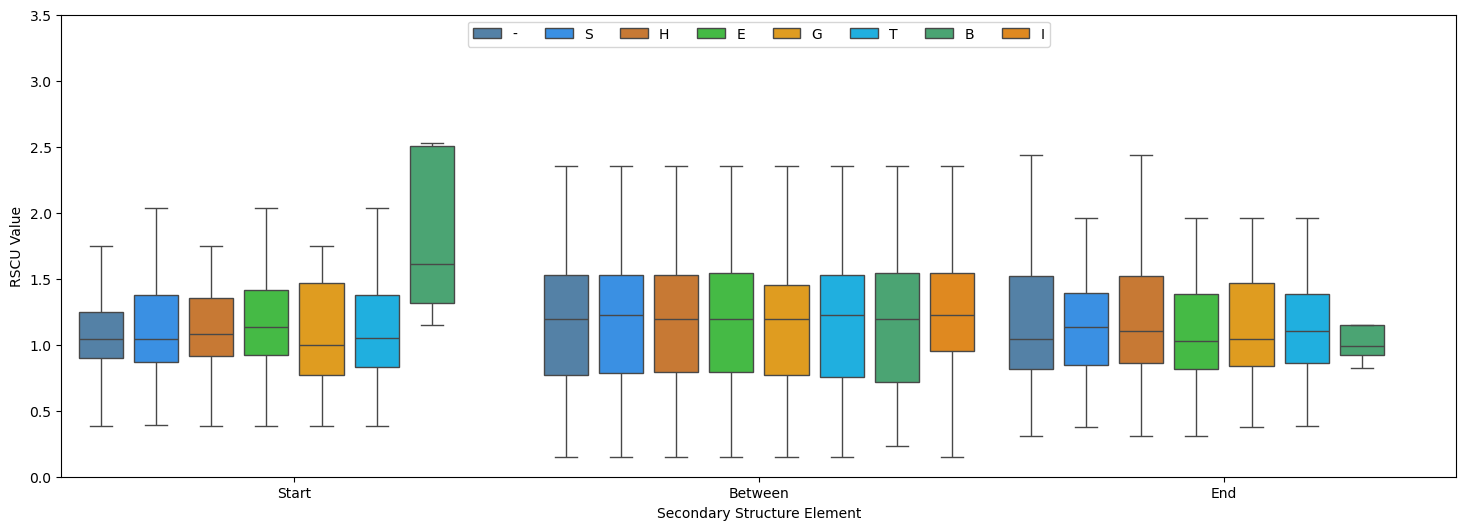

In [8]:
plt.figure(figsize=(18,6))
sns.boxplot(x='Range', y='RSCU', hue='Secondary Structure', data=combined_flat_data, 
                  palette=custom_palette, width=0.95, gap=0.2, showfliers=False)

plt.legend(loc='upper center', ncol=8)
plt.ylabel('RSCU Value')
plt.ylim(0, 3.5)
plt.xlabel('Secondary Structure Element')
plt.xticks(ticks=range(3), labels=['Start', 'Between', 'End'])

if savefig:
    plt.savefig(f'{plot_and_data_name}_RSCU_vs_secondary_structure.png', dpi=600)

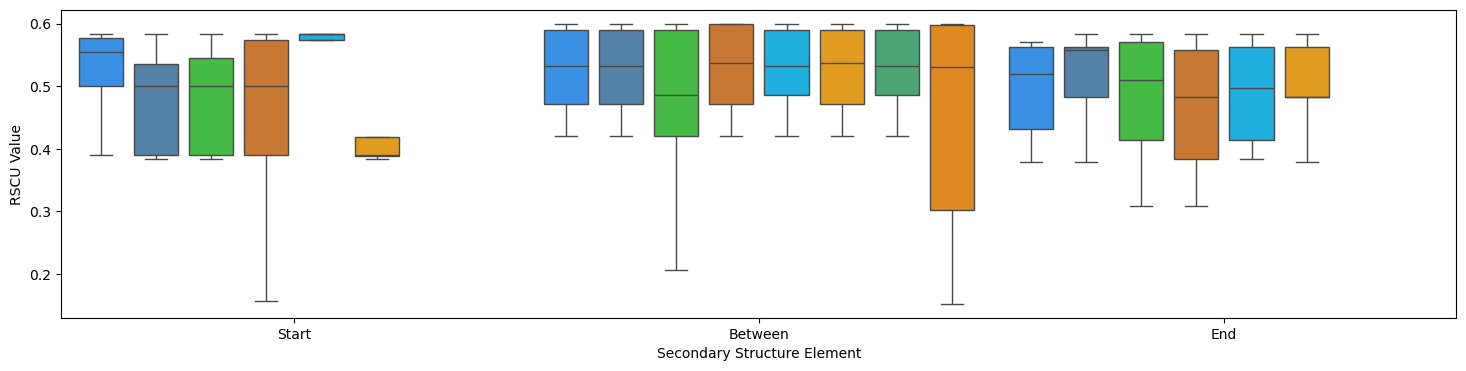

In [9]:
plt.figure(figsize=(18,4))
ax = sns.boxplot(x='Range', y='RSCU', hue='Secondary Structure', data=combined_flat_data_rare, 
                  palette=custom_palette, width=0.95, gap=0.2, showfliers=False)

ax.legend_.remove()
plt.ylabel('RSCU Value')
plt.xlabel('Secondary Structure Element')
plt.xticks(ticks=range(3), labels=['Start', 'Between', 'End'])

if savefig:
    plt.savefig(f'{plot_and_data_name}_RSCU_vs_secondary_structure_rare.png', dpi=600)

In [10]:
# save the overview statistics of the barplots as spreadsheets
grouped_data = combined_flat_data.groupby(['Range', 'Secondary Structure'])
grouped_data.describe().to_excel(f'{plot_and_data_name}RSCU_values_by_secondary_structure_element.xlsx')

grouped_rare_data = combined_flat_data_rare.groupby(['Range', 'Secondary Structure'])
grouped_rare_data.describe().to_excel(f'{plot_and_data_name}_Rare_RSCU_values_by_secondary_structure_element.xlsx')

# Perform a t_test and one_way anova to see if the RSCU values are significant between structure within a range

In [11]:
# initialize empty lists to store results for all ranges
all_p_values = []
all_comparisons = []
all_ranges = []

# the ranges from previous assigned again for reference
ranges = ["Start", "Between", "End"]

for range_name in ranges:
    # get the data for the current range
    # get the secondary structures (were also defined earlier)
    combined_flat_data_range = combined_flat_data[combined_flat_data["Range"] == range_name]
    groups = combined_flat_data_range["Secondary Structure"].unique()

    # calculate p-values for each pair of groups within the current range by conducting a t_test
    for group1, group2 in combinations(groups, 2):
        # loop over all combinations within the ranges and retrieve the RSCU of the group
        group1_data = combined_flat_data_range[combined_flat_data_range["Secondary Structure"] == group1]["RSCU"]
        group2_data = combined_flat_data_range[combined_flat_data_range["Secondary Structure"] == group2]["RSCU"]

        # apply the ttest and get the t_stat and p_value
        t_stat, p_value = ttest_ind(group1_data, group2_data)
        all_p_values.append(p_value) # add the p value
        all_comparisons.append((group1, group2)) # add the comparison of the group
        all_ranges.append(range_name) # add the range

# create a DataFrame for the results
results = pd.DataFrame(all_comparisons, columns=["Group 1", "Group 2"])
results["Range"] = all_ranges
results["P Value"] = all_p_values

# apply Bonferroni correction
# since we do multi comparisons analysis, the p-value is adjusted for type 1 errors
alpha = 0.05
m = len(all_p_values)  # number of comparisons
adjusted_alpha = alpha / m

# check if the rscu between secondary structures are significant
results["Significant"] = results["P Value"] < adjusted_alpha
results.to_csv(f'{plot_and_data_name}_t_test_of_secstru_rscu_within_range.csv')

print(results)

   Group 1 Group 2  Range   P Value  Significant
0        -       S  Start  0.911344        False
1        -       H  Start  0.001162        False
2        -       E  Start  0.010043        False
3        -       G  Start  0.614568        False
4        -       T  Start  0.495771        False
..     ...     ...    ...       ...          ...
65       E       T    End  0.964436        False
66       E       G    End  0.784808        False
67       H       T    End  0.058567        False
68       H       G    End  0.278284        False
69       T       G    End  0.811129        False

[70 rows x 5 columns]


In [13]:
for range_name in ranges:
    # group the secondary structures and save the rscu values to a list
    combined_flat_data_range = combined_flat_data[combined_flat_data["Range"] == range_name]
    g = combined_flat_data_range.groupby("Secondary Structure")["RSCU"].apply(list)

    # calculate a oneway anova for the rscu values of the secondary structure
    f_stat, p_value = stats.f_oneway(*g)
    
    print(f"Anova result for {range_name}")
    print(f"f_stat: {f_stat}, {p_value:e}")
    print(f"Significant: {p_value < adjusted_alpha}")

Anova result for Start
f_stat: 3.6955965342798116, 1.174915e-03
Significant: False
Anova result for Between
f_stat: 8.361126321607326, 3.043727e-10
Significant: True
Anova result for End
f_stat: nan, nan
Significant: False


# Compare and visualize the RSCU between the secondary structure of the ranges 

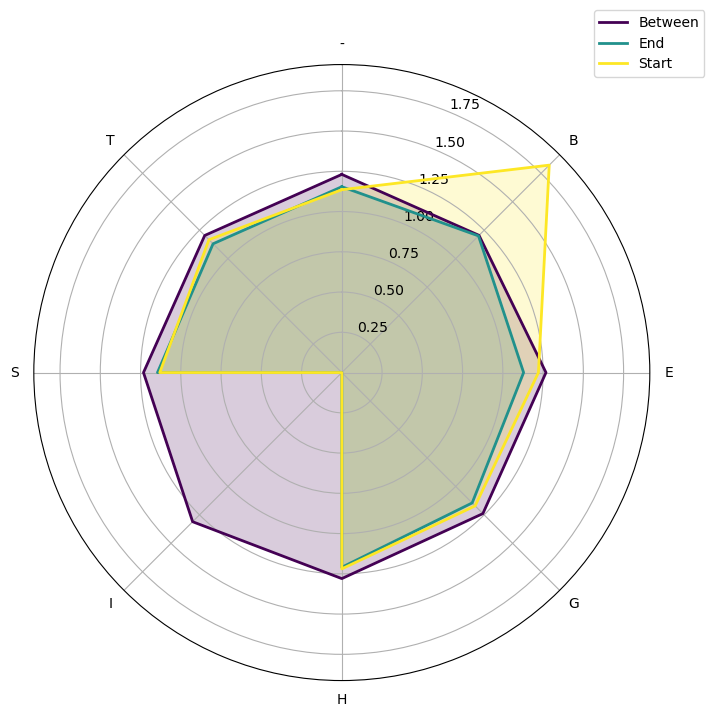

In [14]:
# aggregate the rscu values by secondary structure element and range (take the mean)
# also aggregat the rare rscu values (not plotted here, but were visuealized in the results)
aggregated_data = combined_flat_data.groupby(['Range', 'Secondary Structure'])['RSCU'].mean().unstack()
aggregated_data_rare = combined_flat_data_rare.groupby(['Range', 'Secondary Structure'])['RSCU'].mean().unstack()

# fill any missing values with 0 (or another appropriate value)
aggregated_data = aggregated_data.fillna(0)
aggregated_data_rare = aggregated_data_rare.fillna(0)

# set the labels (the secondary structures from earlier)
# and get the ranges also from earlier
labels = aggregated_data.columns.tolist()
ranges = aggregated_data.index.tolist()

# number of variables to span the radarplot
num_vars = len(labels)

# compute angle for each axis from the number of labels to get a circle
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# repeat the first value to close the circular graph
angles += angles[:1]

# initialize the radar plot
# create subplots of each range
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# draw one axe per variable and add labels
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
plt.xticks(angles[:-1], labels) # the x_ticks are the labels of the circle

# create a color palette based on the number of ranges
colors = plt.cm.viridis(np.linspace(0, 1, len(ranges)))

# plot each range's data for the aggregated data
for range_, color in zip(ranges, colors):
    values = aggregated_data.loc[range_].tolist() # get the values
    values += values[:1] # repeat the first values to connect the line

    # plot the line plot and fill the area
    ax.plot(angles, values, linewidth=2, linestyle='solid', label=range_, color=color)
    ax.fill(angles, values, color=color, alpha=0.2)

plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))

if savefig:
    plt.savefig(f'{plot_and_data_name}_ranges_rscu_radaplot.png', dpi=600)


In [15]:
# save the statistics of the radarplot as a spreadsheet
aggregated_data.groupby("Range").describe().to_excel(f'{plot_and_data_name}_RSCU_values_by_range.xlsx')

# Perform one_way anova to see if the RSCU values are significant between ranges and secondary structure elements

In [16]:
# prepare a dictionary to store ANOVA results
results_anova = {}

for structure in labels:
    # for each secondary structure, get the data
    structure_data = combined_flat_data[['Range', 'Secondary Structure', 'RSCU']]
    structure_data = structure_data[structure_data['Secondary Structure'] == structure]
    
    # prepare data for ANOVA
    data_groups = [structure_data[structure_data['Range'] == range_]['RSCU'] for range_ in ranges]
    
    # perform ANOVA
    f_stat, p_val = stats.f_oneway(*data_groups)
    
    results_anova[structure] = (f_stat, p_val)

for key, value in results_anova.items():
    print(f'{key}: F-statistic = {value[0]}, p-value = {value[1]}')
    print(f"Significant: {p_value < 0.05}")

-: F-statistic = nan, p-value = nan
Significant: False
B: F-statistic = 2.684725770379292, p-value = 0.07032415560074788
Significant: False
E: F-statistic = 7.5154414064500195, p-value = 0.0005500540858533776
Significant: False
G: F-statistic = 1.0503410996929063, p-value = 0.35016272115080627
Significant: False
H: F-statistic = 6.762022635778444, p-value = 0.001160779262258561
Significant: False
I: F-statistic = nan, p-value = nan
Significant: False
S: F-statistic = 3.8484100485951944, p-value = 0.021453286146155656
Significant: False
T: F-statistic = 1.6519433862323936, p-value = 0.19184894615390796
Significant: False


/var/folders/5l/81_dhlw93yqf66d_glxt2vmm0000gn/T/ipykernel_403/1661827062.py:13: DegenerateDataWarning: at least one input has length 0
  f_stat, p_val = stats.f_oneway(*data_groups)


# Calculate the RSCU along the structure position for Coils, Sheets and Helices

### Here the secondary structure types are aggregated as: Coil (T,S,-), Sheet (E,B) and Helix (H,I,G)

In [17]:
# the structure was only extracted from ranges and not in total, so it's done here
data[f'secondary_structure_elements'] = data['secondary_structure'].apply(extract_secondary_structure)

if rscu_from_one_seq:
    # align the rscu values again with the secondary structure elements
    data[f'aligned_rscu'], data[f'aligned_secondary'] = zip(*data.apply(
        lambda row: align_rscu_and_structure(row[f'rscu_values_sequence'], row[f'secondary_structure_elements']), axis=1))
    
else:
    # concatenate the rscu values from the start, between and end
    data[f'nseq_aligned_rscu_total'] = data.apply(lambda row: row[f'nseq_rscu_values_start'] + row[f'nseq_rscu_values_between'] + row[f'nseq_rscu_values_end'], axis=1)
    
    # align the rscu values again with the secondary structure elements
    data[f'aligned_rscu'], data[f'aligned_secondary'] = zip(*data.apply(
        lambda row: align_rscu_and_structure(row[f'nseq_aligned_rscu_total'], row[f'secondary_structure_elements']), axis=1))

# aggregate the secondary structures from dssp to helix, coil and sheet
results = []
secstru_aggregation = {"H": "Helix", "I": "Helix", "G": "Helix", "E": "Sheet", "B": "Sheet", "T": "Coil", "S": "Coil", "-": "Coil"}

# get all segments of adjacent secondary structures
for _, row in data.iterrows():
    current_segment = []
    current_secstru = None
    position = 1 # set a position counter

    for rscu, secstru in zip(row['aligned_rscu'], row['aligned_secondary']):
        secstru = secstru_aggregation[secstru] # assign the overall secondary structure

        # if the secondary structure is the same as the previous, then add to the segment
        if secstru == current_secstru: 
            # add to the segment
            current_segment.append((secstru, position, rscu))
        # when the current segment is over, so a new secondary structure motif is present 
        # then check the length of the segment
        else:
            if current_segment:
                # the segments should not be long than 70 positions (but can be changed otherwise)
                if not ((current_secstru == "Helix" and len(current_segment) >= 70) or
                        (current_secstru == "Sheet" and len(current_segment) >= 70) or
                        current_secstru == "Coil" and len(current_segment) >= 70):

                    # add the segment to the results
                    results.extend(current_segment)

            # set the new segment with the structure element
            current_segment = [(secstru, 1, rscu)]
            current_secstru = secstru
            position = 1  # reset position for new segment
        position += 1 # increase the position within a segment

# create a dataframe to plot the data
df_rscu_position = pd.DataFrame(results, columns=['Secondary Structure', 'Position', 'RSCU'])


# we assume that segments are similar long, so we can apply a rolling mean to smooth the data
df_rscu_position['Smoothed_RSCU'] = df_rscu_position['RSCU'].rolling(window=3, min_periods=1, center=True).mean()

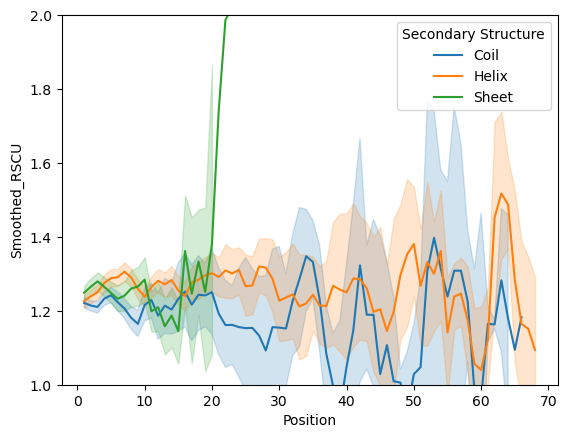

In [18]:
# create a line plot with the standard deviation
sns.lineplot(x="Position", y="Smoothed_RSCU", hue="Secondary Structure", data=df_rscu_position)
plt.ylim(1,2)
if savefig: 
    plt.savefig('RSCU_by_position.png')